In [5]:
from shapely.geometry import Polygon
from pyproj import Geod
import math
import scipy
import chaosmagpy as cp
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def dx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dxm)
    der[:, 0] = (f[:, 1] - f[:, -2]) / (2 * dxm)
    der[:, -1] = der[:, 0]
    return der

def dy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dym)
    der[0, :] = (f[1, :] - f[0, :]) / dym
    der[1, :] = (f[-1, :] - f[-2, :]) / dym
    return der

def ddy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, 1, axis=0) - 2 * f + np.roll(f, -1, axis=0)) / (dym ** 2)
    der[0, :] = der[1, :]
    der[-1, :] = der[-2, :]
    return der

def ddx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, 1, axis=1) - 2 * f + np.roll(f, -1, axis=1)) / (dxm ** 2)
    der[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -2]) / (dxm ** 2)
    der[:, -1] = der[:, 0]
    return der


def detH(ddx, ddy):
    derH = (ddx * ddy)
    return derH

def read_gauss_coeffs(filename, target_year, lmax=25):
    """
    已经经过修正的20250703
    Histkalmag格式的文件中读取指定年份的高斯系数，
    输出 gsh 和 hsh 按 (l, m) 顺序排列。
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    years = list(map(float, lines[0].strip().split()))
    if target_year not in years:
        raise ValueError(f"目标年份 {target_year} 不在数据中")
    idx = years.index(target_year)

    coeff_lines = lines[1:len(lines)]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]

    coeffs_at_year = [row[idx] for row in coeffs]
    gsh = []
    hsh = []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            if m == 0:
                gsh.append(coeffs_at_year[i])
                i += 1
                hsh.append(0.0)
            else:
                gsh.append(coeffs_at_year[i])
                i += 1
                hsh.append(coeffs_at_year[i])
                i += 1
    return np.array(gsh), np.array(hsh)


# 计算主磁场
def magnetic_field(gsh, hsh, lmax, r, lats, lons):
    a = 6371.2
    pi = math.pi
    # lats          =  np.linspace(1., 179., num=181)
    # lons          =  np.linspace(-180., 180., num=181)
    lons2d, lats2d = np.meshgrid(lons, lats)
    phi = lons2d
    cost2d = np.cos((lats2d) * np.pi / 180)
    i = 0
    br = np.zeros(cost2d.shape)
    bphi = np.zeros(cost2d.shape)
    btheta = np.zeros(cost2d.shape)
    for l in np.arange(1, lmax + 1, 1):
        for m in np.arange(0, l + 1, 1):
            g = gsh[i]
            h = hsh[i]
            # calculate schmidt
            if m == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0) ** m) * np.sqrt(2.0 * math.factorial(l - m) / math.factorial(l + m))
            lagendre = scipy.special.lpmv(m, l, cost2d)
            lagendre_ = scipy.special.lpmv(m, l - 1, cost2d)
            div_lagendre = (l * cost2d * lagendre - (l + m) * lagendre_) / np.sqrt(1 - cost2d ** 2)
            br = br + schmidt * (float(l) + 1.0) * ((a / r) ** (l + 2)) * lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0)
                        + h * np.sin(float(m) * phi * pi / 180.0))
            bphi = bphi + schmidt * (m / np.sin((lats2d) * pi / 180)) * ((a / r) ** (l + 2)) * lagendre * (
                        -g * np.sin(float(m) * phi * pi / 180.0)
                        + h * np.cos(float(m) * phi * pi / 180.0))
            btheta = btheta + schmidt * ((a / r) ** (l + 2)) * (div_lagendre) * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            i += 1
    return br, bphi, btheta, lons2d, lats2d


def mean_F(f, thetam):
    theta_rad = np.deg2rad(thetam)
    sin = np.sin(theta_rad)
    product_sum = np.sum(f[30:151, :] * sin[30:151, :])
    C = np.sum(sin[30:151, :])
    mean = product_sum / C
    return mean


def calculate_integral(B):
    # 计算归一化 积分
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)  # 经度范围
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)  # 纬度范围

    integrals = [0, 0]
    theta_min = np.deg2rad(25)
    theta_max = np.deg2rad(155)
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],
        [(0, 2 * np.pi), (theta_max, np.pi)]]
    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and region[1][0] <= (
                        theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta
    integral = sum(integrals)
    return integral


# 计算Fout
def F_boundary(constant, B, B_t0):
    Fup = calculate_integral(B)
    Fdown = calculate_integral(B_t0)
    F_out = Fup / Fdown
    # F边界
    boundaryF = constant * F_out
    return boundaryF

In [7]:
def pointF_Chaos(time,colatlist,lonlist):
    model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')
    radius=6371
    if np.isscalar(colatlist):
        # 单点，grid=False
        Bx, By, Bz = model.synth_values_tdep(time, radius, colatlist, lonlist, grid=False)
    else:
        # 多点，默认grid=True
        Bx, By, Bz = model.synth_values_tdep(time, radius, colatlist, lonlist)

    F = np.sqrt(Bx ** 2 + By ** 2 + Bz ** 2) / 1000
    return F

In [8]:
def F_C_ObO(x, y, fun1,fun2,lev):
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])

    Line_dx=[]
    points_dx=[]
    paths = c_fx.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dx.extend(verts)
        FxLine=[]
        for v in range(len(verts) - zz):
            xa,ya=verts[v]
            xb,yb=verts[v+1]
            xlist= np.array([xa,xb])
            ylist= np.array([ya,yb])
            # 如果两个点太近（避免 polyfit 崩溃）
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue  # 跳过这对点
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"警告：polyfit 在点 ({xa}, {ya}) - ({xb}, {yb}) 拟合失败，已跳过。")
                continue
    
            k, b = np.polyfit(xlist, ylist, deg=1)
            FxLine.append([k, b, xa, xb, ya, yb])
    
        Line_dx.append(np.array(FxLine))
    
    Line_dy = []
    points_dy=[]
    paths = c_fy.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly

        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dy.extend(verts)
        FyLine=[]
        for v in range(len(verts) - zz):
            xa,ya=verts[v]
            xb,yb=verts[v+1]
            xlist= np.array([xa,xb])
            ylist= np.array([ya,yb])
            # 如果两个点太近（避免 polyfit 崩溃）
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue  # 跳过这对点
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"警告：polyfit 在点 ({xa}, {ya}) - ({xb}, {yb}) 拟合失败，已跳过。")
                continue
    
            k, b = np.polyfit(xlist, ylist, deg=1)
            FyLine.append([k, b, xa, xb, ya, yb])
        Line_dy.append(np.array(FyLine))
    
    x_cross=[]
    y_cross=[]
    for n in range(0, len(Line_dx)):
        Fx = Line_dx[n]
        for m in range(0, len(Line_dy)):
            Fy = Line_dy[m]
            for p in range(0, len(Fx[:,0])):
                k1,b1,x1,x2,y1,y2=Fx[p, :]
                for q in range(0, len(Fy[:,0])):
                    k2,b2,x3,x4,y3,y4=Fy[q, :]
                    x_c= (b2 - b1) / (k1 - k2)
                    if x_c is not None:
                        # 判断x_c是否在两段线段的x范围内
                        in_range_1 = (min(x1, x2) <= x_c <= max(x1, x2))
                        in_range_2 = (min(x3, x4) <= x_c <= max(x3, x4))
                        if in_range_1 and in_range_2:
                            y_c = k1 * x_c + b1
                            if y_c is not None:
                                # 判断x_c是否在两段线段的x范围内
                                in_range_3 = (min(y1, y2) <= y_c <= max(y1, y2))
                                in_range_4 = (min(y3, y4) <= y_c <= max(y3, y4))
                                if in_range_3 and in_range_4:
                                    x_cross.append(x_c)
                                    y_cross.append(y_c)
    
    x_cross = np.array(x_cross)
    y_cross = np.array(y_cross)
    
    # 创建布尔掩码，筛选 x 在 [5, 175] 范围内的点
    mask = (y_cross >= 5) & (y_cross <= 175)
    x_cross = x_cross[mask]
    y_cross = y_cross[mask]
    return x_cross,y_cross


def detH_saddle(DETH, thetam, phim, crossingsX,crossingsY):

    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]

    interp_func = scipy.interpolate.RegularGridInterpolator((lat_grid, lon_grid), DETH,
                                                            bounds_error=False,
                                                            fill_value=np.nan)
    cross = np.column_stack((crossingsX, crossingsY))
    cross = np.array(cross)
    points_for_interp = cross[:, [1, 0]]
    # 插值
    values = interp_func(points_for_interp)


    # 分类
    pos_mask = values > 0
    neg_mask = values <= 0

    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points

D:\Anaconda\envs\Saddle\Lib\site-packages\chaosmagpy\chaos.py:2873: UserWarning: Missing ionospheric field coefficients: 'model_ion'
  warnings.warn(f'Missing ionospheric field coefficients: {err}')


2000
6
Fout= 99728410.47984083
Fc 的 center of mass： lat= 111.51939984528718 lon= 320.24313510840426
2001
6
Fout= 100095354.66094457
Fc 的 center of mass： lat= 111.50922178316166 lon= 320.0363406608651
2002
6
Fout= 100425372.93278107
Fc 的 center of mass： lat= 111.47602396356342 lon= 319.8028455223306
2003


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


警告：polyfit 在点 (0.0, 18.13338428006969) - (0.0, 27.954768240897813) 拟合失败，已跳过。
6
Fout= 100705633.31411721
Fc 的 center of mass： lat= 111.47341237007943 lon= 319.585724864452
2004
警告：polyfit 在点 (0.0, 18.842043394095217) - (0.0, 27.360189191038245) 拟合失败，已跳过。
6
Fout= 100951252.98390639
Fc 的 center of mass： lat= 111.47288245735976 lon= 319.32953096527774
2005
警告：polyfit 在点 (0.0, 19.46853508891411) - (0.0, 26.833026175129156) 拟合失败，已跳过。
6
Fout= 101209092.21515498
Fc 的 center of mass： lat= 111.4794179564268 lon= 319.0445970327088
2006
警告：polyfit 在点 (0.0, 20.13171085513104) - (0.0, 26.2168497841218) 拟合失败，已跳过。
6
Fout= 101372794.74283531
Fc 的 center of mass： lat= 111.45578599828156 lon= 318.752667920564
2007
警告：polyfit 在点 (0.0, 20.935541945623314) - (0.0, 25.45979127724847) 拟合失败，已跳过。
6
Fout= 101519391.4303703
Fc 的 center of mass： lat= 111.47230367147036 lon= 318.4241676388031
2008
警告：polyfit 在点 (0.0, 22.289459201059373) - (0.0, 24.16371893109367) 拟合失败，已跳过。
8
Fout= 101629708.66210625
Fc 的 center of 

C:\Users\yue-y\AppData\Local\Temp\ipykernel_30380\1225394214.py:58: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
C:\Users\yue-y\AppData\Local\Temp\ipykernel_30380\1225394214.py:63: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit(xlist, ylist, deg=1)


8
Fout= 106208603.02646458
Fc 的 center of mass： lat= 111.24291356482983 lon= 314.36321031448483
Area number= 2 
 Area= [12380092.12626026  1537834.28906114]


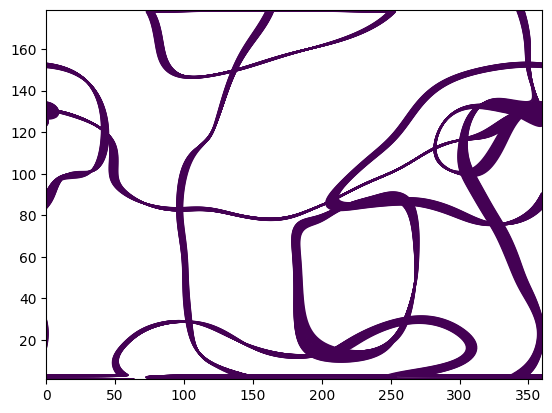

In [9]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')
time2020 = cp.data_utils.mjd2000(2020, 1, 1)  # modified Julian date
B_radius, B_theta, B_phi = model.synth_values_tdep(time2020, radiusm, thetam, phim)
F2020 = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
Fo2020 = calculate_integral(F2020)

#改动 center of math 计算
from matplotlib.ticker import ScalarFormatter
import chaosmagpy as cp
import matplotlib.colors as mcolors

cmap="RdGy"# 'PuOr_r'
linecolor="forestgreen"
vmin = 20
vmax = 70

fontweight='bold'
fontname='Arial'
fontsize=14
markersize = 70
SaddleColor="k"
SaddleMarker="o"
ExtremaColor="white"
ExtremaMarker="^"

massmarker_Fs="+"
massmarker="x"
masscolor="forestgreen"
masssize=60

pek_yr_fin = []
pek_f_fin = []
pek_lat_fin = []
pek_lon_fin = []
Fc_area_fin = []
Fc_cm_lat_fin = []
Fc_cm_phi_fin = []
Fc_cm_F_fin = []
Fc_cm_yr_fin = []
Fs_area_fin = []
Fs_cm_lat_fin = []
Fs_cm_lon_fin = []
Fs_cm_yr_fin = []
Fs_cm_F_fin = []
for year in range(2000,2025,1):
    yr=year
    print(yr)
    time = cp.data_utils.mjd2000(yr, 1, 1)  # modified Julian date
    B_radius, B_theta, B_phi = model.synth_values_tdep(time, radiusm, thetam, phim)
    F = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
    Fout = calculate_integral(F)
    Fc = 32 * (Fout / Fo2020)

    vcenter = Fc  # 想让这个值为白色
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    F_real = F
    d_x = dx(thetam, phim, F_real)
    d_y = dy(thetam, phim, F_real)
    dd_x = ddx(thetam, phim, F_real)
    dd_y = ddy(thetam, phim, F_real)

    DETH = detH(dd_x, dd_y)
    crossingsX1, crossingsY1= F_C_ObO(phi, theta, d_x, d_y,0)
    E, S = detH_saddle(DETH, thetam, phim, crossingsX1, crossingsY1)
    H_S_lat, H_S_lon=S[:,0],S[:,1]
    H_E_lat, H_E_lon=E[:,0],E[:,1]
    print(len(crossingsX1))

    c_fo = plt.contour(phi, theta, F, levels=[Fc])   # get contour
    paths = c_fo.get_paths()          # get contour path(all)
    polygons1 = paths[0].to_polygons()
    area_same_fo=[]
    # 准备网格点坐标
    lat_grid = 90 - thetam    # 纬度 φ
    lon_grid = phim           # 经度 φ
    theta_grid = thetam

    # 准备存储结果
    centers_phi_theta = []
    All_phi_inside = []
    All_theta_inside = []
    All_F_inside = []
    # 遍历每个封闭区域
    for path in paths:
        for poly in path.to_polygons():
            lats_fo = 90 - poly[:, 1]
            lons_fo = poly[:, 0]
            geod = Geod(ellps="WGS84")
            polygon = Polygon(zip(lons_fo, lats_fo))
            area_fo, _ = geod.geometry_area_perimeter(polygon)
            area_km2_fo = abs(area_fo) / 1e6
            area_same_fo.append(area_km2_fo)

            poly_lats = 90 - poly[:, 1]
            poly_lons = poly[:, 0]

            polygon_path = Path(np.vstack([poly_lons, poly_lats]).T)
            grid_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

            inside = polygon_path.contains_points(grid_points)
            if not np.any(inside):
                continue

            # 提取区域内的经度、余纬和磁强度
            phi_in = grid_points[inside, 0]                      # 经度
            theta_in = theta_grid.ravel()[inside]                # 余纬
            F_in = F.ravel()[inside]                             # 磁场强度

            All_phi_inside.append(phi_in)
            All_theta_inside.append(theta_in)
            All_F_inside.append(F_in)
    area_same_total_fo = np.sum(area_same_fo)
    area_km2_fo = area_same_total_fo
    print("Fout=",area_km2_fo)

    All_phi_inside = np.concatenate(All_phi_inside)
    All_theta_inside = np.concatenate(All_theta_inside)
    All_F_inside = np.concatenate(All_F_inside)
    All_phi_inside = ((All_phi_inside + 180) % 360) - 180
    # 加权计算质心
    w_sum = (1/All_F_inside)
    w_sin = np.sin(All_theta_inside*np.pi/180)
    phi_cm_Fc = np.sum(All_phi_inside * w_sum * w_sin) / np.sum(w_sum * w_sin)
    phi_cm_Fc = phi_cm_Fc % 360
    theta_cm_Fc = np.sum(All_theta_inside * w_sin  *  w_sum ) /  np.sum(w_sum * w_sin)           # 保留余纬
    print("Fc 的 center of mass：","lat=",theta_cm_Fc,"lon=",phi_cm_Fc)


    # F minima find
    B_radius_min, B_theta_min, B_phi_min = model.synth_values_tdep(time, radius, H_E_lat,H_E_lon,grid=True)
    F_mini = np.sqrt(B_radius_min ** 2 + B_theta_min ** 2 + B_phi_min ** 2) / 1000
    pek_f=[]
    pek_lat=[]
    pek_lon=[]
    for i in range(0,len(H_E_lat)):
        if F_mini[i,i] < Fc:
            pek_f.append( F_mini[i,i])
            pek_lat.append(H_E_lat[i])
            pek_lon.append(H_E_lon[i])
    pek_f = np.array(pek_f)
    pek_lat = np.array(pek_lat)
    pek_lon = np.array(pek_lon)

    # 关于Fc的计算全部完成。准备装组
    for z in range(len(pek_f)):
        pek_yr_fin.append(yr)
        pek_f_fin.append(pek_f[z])
        pek_lat_fin.append(pek_lat[z])
        pek_lon_fin.append(pek_lon[z])

    Fc_area_fin.append(area_km2_fo)
    Fc_cm_lat_fin.append(theta_cm_Fc)
    Fc_cm_phi_fin.append(phi_cm_Fc)
    Fc_cm_F_fin.append(pointF_Chaos(yr, theta_cm_Fc, phi_cm_Fc))
    Fc_cm_yr_fin.append(yr)



    # F saddle 的计算
    B_radius, B_theta, B_phi = model.synth_values_tdep(time, radius, H_S_lat,H_S_lon,grid=True)
    F_saddle = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
    F_right=[]
    for i in range(0,len(H_S_lat)):
        if F_saddle[i,i] < Fc:
            F_right = F_saddle[i,i]
            saddle_lat=H_S_lat[i]
            saddle_lon=H_S_lon[i]

    Saddle_centers_phi_theta = []
    Fs_phi_inside = []
    Fs_theta_inside = []
    Fs_F_inside = []
    if F_right:  # if have Saddle point
        c_fc = plt.contour(phi, theta, F, levels=[F_right*0.9999])
        num_contours = len(c_fc.get_paths())
        paths = c_fc.get_paths()
        polygons = paths[0].to_polygons()

        selected_polygon = None
        area_array=[]
        area_dif=[]
        area_same=[]
        for i, poly in enumerate(polygons):
            lats= 90-poly[:, 1]
            lons= poly[:, 0]

            geod = Geod(ellps="WGS84")
            polygon = Polygon(zip(lons, lats))
            area, _ = geod.geometry_area_perimeter(polygon)
            area_km2 = abs(area) / 1e6

            poly_lats = 90 - poly[:, 1]
            poly_lons = poly[:, 0]

            polygon_path = Path(np.vstack([poly_lons, poly_lats]).T)
            grid_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

            inside = polygon_path.contains_points(grid_points)
            if not np.any(inside):
                continue

            # 提取区域内的经度、余纬和磁强度
            phi_in = grid_points[inside, 0]                      # 经度
            theta_in = theta_grid.ravel()[inside]                # 余纬
            F_in = F.ravel()[inside]                             # 磁场强度

            if ((lons >= 0) & (lons <= 1)).any() or ((lons >= 359) & (lons <= 360)).any():
                area_same.append(area_km2)

                # 遇到0°需要加和
                Fs_phi_inside.append(phi_in)
                Fs_theta_inside.append(theta_in)
                Fs_F_inside.append(F_in)

            else:
                area_dif.append(area_km2)
                # 加权计算质心
                w_sum = 1 / F_in
                w_sin = np.sin(theta_in * np.pi / 180)
                phi_cm = np.sum(phi_in * w_sum * w_sin) / np.sum(w_sum * w_sin)
                theta_cm = np.sum(theta_in * w_sum * w_sin) / np.sum(w_sum * w_sin)  # 保留余纬

                Saddle_centers_phi_theta.append((phi_cm, theta_cm))

        if Fs_phi_inside:
            #center of mass 计算
            Fs_phi_inside = np.concatenate(Fs_phi_inside)
            Fs_theta_inside = np.concatenate(Fs_theta_inside)
            Fs_F_inside = np.concatenate(Fs_F_inside)
            Fs_phi_inside = ((Fs_phi_inside + 180) % 360) - 180  # 映射到 [-180, 180]
            # 加权计算质心
            w_sum =  (1 / Fs_F_inside)
            w_sin = np.sin(Fs_theta_inside * np.pi / 180)
            phi_cm_Fs = np.sum(Fs_phi_inside * w_sin * w_sum) / np.sum(w_sum * w_sin)
            phi_cm_Fs = phi_cm_Fs % 360
            theta_cm_Fs = np.sum(Fs_theta_inside * w_sin * w_sum) / np.sum(w_sum * w_sin)
            Saddle_centers_phi_theta.append((phi_cm_Fs, theta_cm_Fs))
        Saddle_centers_phi_theta = np.array(Saddle_centers_phi_theta)

        #面积计算
        area_same_total = np.sum(area_same)

        area_dif = np.array(area_dif)
        area_array = np.hstack([area_dif, area_same_total])
        print("Area number=",len(area_array),"\n Area=",area_array)



        Fcm_Fs = pointF_Chaos(yr, Saddle_centers_phi_theta[:, 1], Saddle_centers_phi_theta[:, 0])
        Fs_cm_lat_fin.extend(Saddle_centers_phi_theta[:, 1])
        Fs_cm_lon_fin.extend(Saddle_centers_phi_theta[:, 0])
        Fs_cm_yr_fin.extend([yr] * len(Saddle_centers_phi_theta))
        Fs_cm_F_fin.extend(Fcm_Fs)
        Fs_area_fin.append([yr, *area_array])

In [10]:
print(Fs_area_fin)
data=Fs_area_fin

cleaned = [[row[0], row[1], row[2]] for row in data]

# 转换成 numpy 数组
Fs_area_fin_clean = np.array(cleaned)
print(cleaned)

[[2008, np.float64(16500035.576077074), np.float64(381.42543581829835), np.float64(0.0)], [2009, np.float64(16233821.964339541), np.float64(56655.89306270462)], [2010, np.float64(15940078.345412035), np.float64(131165.98512033193)], [2011, np.float64(15655246.112262303), np.float64(206828.54709728737)], [2012, np.float64(15411427.649163803), np.float64(280394.138689403)], [2013, np.float64(15169233.901160145), np.float64(354987.93682851235)], [2014, np.float64(14965896.86373094), np.float64(442454.15755421156)], [2015, np.float64(14717306.218663383), np.float64(533483.1540086509)], [2016, np.float64(14466577.07617866), np.float64(647827.9958753631)], [2017, np.float64(14252876.642638521), np.float64(768867.4631755584)], [2018, np.float64(13989939.291619763), np.float64(871188.4238049036)], [2019, np.float64(13757815.960485738), np.float64(990081.0444023501)], [2020, np.float64(13477877.11076173), np.float64(1096108.9048448598)], [2021, np.float64(13223170.568951294), np.float64(1202606

In [11]:
def lon_360_to_180(lon_array):
    lon_array = np.array(lon_array)
    lon_array = (lon_array + 180) % 360 - 180
    return lon_array
Fs_cm_lon_fin_180 = lon_360_to_180(Fs_cm_lon_fin)
Fc_cm_phi_fin_180 = lon_360_to_180(Fc_cm_phi_fin)
pek_lon_fin_180 = lon_360_to_180(pek_lon_fin)


Fs_area_fin_arr=np.array(Fs_area_fin_clean)
#计算的面积百分比
per_1 = Fc_area_fin[8:] * (Fs_area_fin_arr[:, 1]/(Fs_area_fin_arr[:, 1] + Fs_area_fin_arr[:, 2]))
per_2 = Fc_area_fin[8:] * (Fs_area_fin_arr[:, 2]/(Fs_area_fin_arr[:, 1] + Fs_area_fin_arr[:, 2]))


In [12]:
print(pek_yr_fin, pek_f_fin)

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2008, 2009, 2009, 2010, 2010, 2011, 2011, 2012, 2012, 2013, 2013, 2014, 2014, 2015, 2015, 2016, 2016, 2017, 2017, 2018, 2018, 2019, 2019, 2020, 2020, 2021, 2021, 2022, 2022, 2023, 2023, 2024, 2024] [np.float64(22.888376467738556), np.float64(22.85897603791923), np.float64(22.830628418091194), np.float64(22.80030743101189), np.float64(22.773426200434763), np.float64(22.742537895005363), np.float64(22.71052865601916), np.float64(22.678867735517347), np.float64(24.793395377256875), np.float64(22.64989765172462), np.float64(24.728479718145053), np.float64(22.61978456476935), np.float64(24.657267352947198), np.float64(22.58619948732227), np.float64(24.581128435573238), np.float64(22.549977753837684), np.float64(24.50670795943223), np.float64(22.51021303386694), np.float64(24.43251248430098), np.float64(22.46969367161357), np.float64(24.35921693053208), np.float64(22.430155750055953), np.float64(24.28683381227545), np.float64(22.39539941

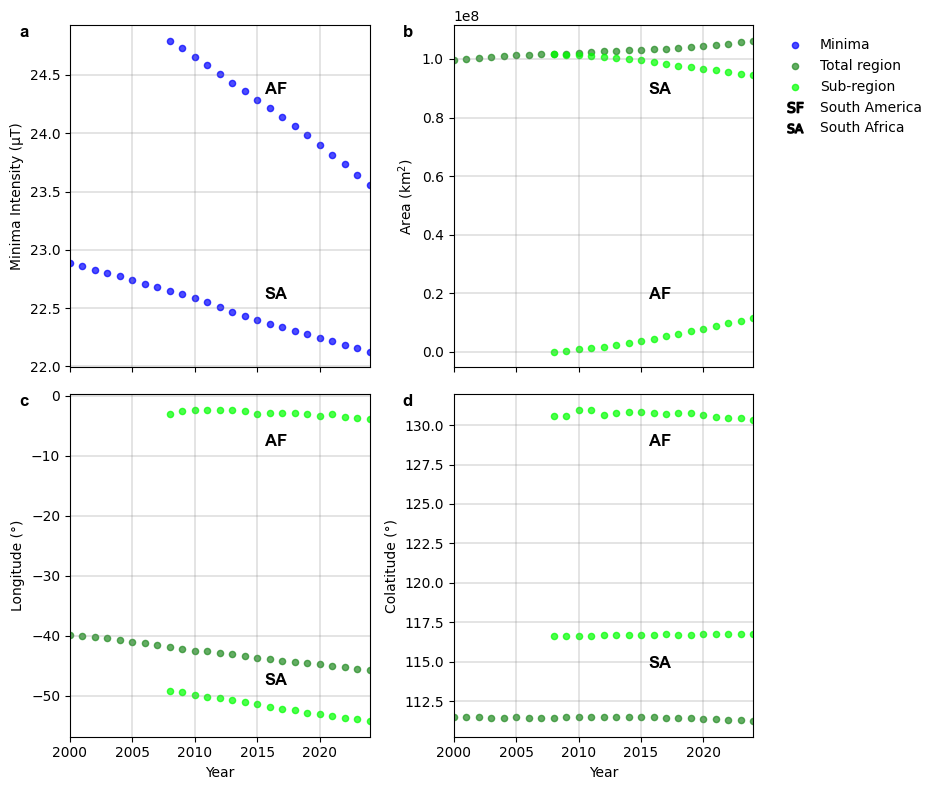

In [30]:
import matplotlib.pyplot as plt
import numpy as np


sa_handle = Line2D([], [], linestyle='None',
                   marker=r'$\mathrm{SA}$',
                   markersize=11,
                   color='black',
                   label='South Africa')

sf_handle = Line2D([], [], linestyle='None',
                   marker=r'$\mathrm{SF}$',
                   markersize=11,
                   color='black',
                   label='South America')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

marker_size = 20
subregionCMcolor = 'lime'
lightgreen = 'lightgreen'

# ---------- Panel (a): Minima intensity ----------
axs[0, 0].scatter(pek_yr_fin, pek_f_fin, s=marker_size, color='blue', marker='o', alpha=0.7, label=r'Minima')
# axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Minima Intensity (μT)')
axs[0, 0].set_xlim(2000, 2024)

# ---------- Panel (b): Area ----------
Fs_area_fin_arr = np.array(Fs_area_fin_clean)

axs[0, 1].scatter(Fc_cm_yr_fin, Fc_area_fin,  s=marker_size,color='forestgreen', alpha=0.7, marker='o', label=r'Total region')
axs[0, 1].scatter(Fs_area_fin_arr[:, 0], per_1,  s=marker_size,color=subregionCMcolor, alpha=0.7, marker='o', label=r'$Sub-region$')
axs[0, 1].scatter(Fs_area_fin_arr[:, 0], per_2, s=marker_size, color=subregionCMcolor, alpha=0.7, marker='o')
# axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Area (km$^2$)')
axs[0, 1].set_xlim(2000, 2024)

# ---------- Panel (c): Longitude ----------
axs[1, 0].scatter(Fs_cm_yr_fin, Fs_cm_lon_fin_180, s=marker_size, color=subregionCMcolor, marker='o', alpha=0.7, label=r'$F_{cm}$ of $A_{saddle}$')
axs[1, 0].scatter(Fc_cm_yr_fin, Fc_cm_phi_fin_180, s=marker_size, color='forestgreen', marker='o', alpha=0.7, label=r'$F_{cm}$ of $A_c$')

axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Longitude (°)')
axs[1, 0].set_xlim(2000, 2024)

# ---------- Panel (d): Colatitude ----------
axs[1, 1].scatter(Fc_cm_yr_fin, Fc_cm_lat_fin, s=marker_size, color='forestgreen', marker='o', alpha=0.7, label=r'Total region')
axs[1, 1].scatter(Fs_cm_yr_fin, Fs_cm_lat_fin, s=marker_size, color=subregionCMcolor, marker='o', alpha=0.7, label=r'Sub-region')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Colatitude (°)')
axs[1, 1].set_xlim(2000, 2024)

axs[0, 1].tick_params(axis='x', labelbottom=False)
axs[0, 0].tick_params(axis='x', labelbottom=False)
# ---------- Grid ----------
for ax in axs.flat:
    ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.3)

# ---------- AF / SA labels (all panels) ----------
axs[0,0].text(0.65,0.80,'AF',transform=axs[0,0].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')
axs[0,0].text(0.65,0.20,'SA',transform=axs[0,0].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')

axs[0,1].text(0.65,0.80,'SA',transform=axs[0,1].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')
axs[0,1].text(0.65,0.20,'AF',transform=axs[0,1].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')

axs[1,0].text(0.65,0.85,'AF',transform=axs[1,0].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')
axs[1,0].text(0.65,0.15,'SA',transform=axs[1,0].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')

axs[1,1].text(0.65,0.85,'AF',transform=axs[1,1].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')
axs[1,1].text(0.65,0.20,'SA',transform=axs[1,1].transAxes,fontsize=12,fontweight='bold',fontfamily='Arial')

# ---------- Panel labels ----------
labels = ['a', 'b', 'c', 'd']
for ax, lab in zip(axs.flat, labels):
    ax.text(-0.17, 1.00, lab, transform=ax.transAxes,
            fontsize=12, fontweight='bold', fontfamily='Arial',
            va='top', ha='left')

# ---------- Legend (merged) ----------
from matplotlib.lines import Line2D

# ---------- Legend (merged) ----------
# 先拿已有 legend
handles1, labels1 = axs[0, 0].get_legend_handles_labels()
handles4, labels4 = axs[1, 1].get_legend_handles_labels()

# 合并
handles = handles1 + handles4 + [sf_handle, sa_handle]
labels  = labels1  + labels4  + ['South America', 'South Africa']

axs[0, 1].legend(
    handles,
    labels ,
    loc='upper left',
    bbox_to_anchor=(1.05, 1.0),
    frameon=False
)
# ---------- Layout & save ----------
plt.tight_layout(rect=[0, 0, 0.95, 1])
# plt.savefig("D:/work/work_saddle/Latex_saddle/Fig/New-color/7_Area_CHAOS.png", dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
# Fs_area_fin_arr[:, 0], per_1
x=Fc_cm_yr_fin
y=Fc_cm_lat_fin
# 线性拟合
coeffs = np.polyfit(x, y, 1)  # 一次多项式拟合
rate = coeffs[0]  # 斜率 a
intercept = coeffs[1]
rate

In [ ]:
Fs_cm_yr_fin, Fs_cm_lat_fin

In [ ]:

x_need=np.array(Fs_cm_yr_fin)
y_need=np.array(Fs_cm_lat_fin)

mask2 =y_need >(120)
mask1 = ~mask2

x1, y1 = x_need[mask1],y_need[mask1]  # 主曲线
x2, y2 = x_need[mask2],y_need[mask2]  # 第二条曲线（2008后出现）

# 分别线性拟合
coef1 = np.polyfit(x1, y1, 1)
coef2 = np.polyfit(x2, y2, 1)

rate1 = coef1[0] 
rate2 = coef2[0] 
#总 minima 的速率和 sub minima速率
rate1,rate2

In [ ]:
x1, y1

In [ ]:
# total area
x=Fc_cm_yr_fin
y=Fc_cm_phi_fin_180
# 线性拟合
coeffs = np.polyfit(x, y, 1)  # 一次多项式拟合
rate = coeffs[0]  # 斜率 a
intercept = coeffs[1]
rate
# round(rate*(1e-6), 2)

In [ ]:
# sub-region sub
x=Fs_area_fin_arr[:, 0]
y=per_2
# 线性拟合
coeffs = np.polyfit(x, y, 1)  # 一次多项式拟合
rate = coeffs[0]  # 斜率 a
intercept = coeffs[1]
rate
round(rate*(1e-6), 2)

In [ ]:
# sub-region primry
x=Fs_area_fin_arr[:, 0]
y=per_1
# 线性拟合
coeffs = np.polyfit(x, y, 1)  # 一次多项式拟合
rate = coeffs[0]  # 斜率 a
intercept = coeffs[1]
rate
round(rate*(1e-6), 2)

In [ ]:
0.74-0.48

In [ ]:
round(rate*(1e-6), 2)

In [ ]:
pek_yr_fin, pek_lat_fin

pek_yr_fin_180=np.array(pek_yr_fin)
pek_lat_fin=np.array(pek_lat_fin)

mask2 =pek_lat_fin[8:] < 120
mask1 = ~mask2

x1, y1 = pek_yr_fin[8:][mask1],pek_lat_fin[8:][mask1]  # 主曲线
x2, y2 = pek_yr_fin[8:][mask2], pek_lat_fin[8:][mask2]  # 第二条曲线（2008后出现）

# 分别线性拟合
coef1 = np.polyfit(x1, y1, 1)
coef2 = np.polyfit(x2, y2, 1)

rate1 = coef1[0] 
rate2 = coef2[0] 
#总 minima 的速率和 sub minima速率
rate1,rate2

In [52]:
x1, y1

(array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
        2019, 2020, 2021, 2022, 2023, 2024]),
 array([130.75172391, 130.81645466, 130.85007578, 130.86930967,
        130.87350102, 130.91324755, 130.93861925, 130.94674286,
        130.94219326, 130.92616641, 130.90106346, 130.86704598,
        130.81818396, 130.77105203, 130.70732398, 130.63275   ,
        130.55485158]))

In [36]:
pek_yr_fin[8:], pek_lon_fin_180[8:]

(array([2008, 2008, 2009, 2009, 2010, 2010, 2011, 2011, 2012, 2012, 2013,
        2013, 2014, 2014, 2015, 2015, 2016, 2016, 2017, 2017, 2018, 2018,
        2019, 2019, 2020, 2020, 2021, 2021, 2022, 2022, 2023, 2023, 2024,
        2024]),
 array([ -2.82964598, -56.08860161,  -2.03802743, -56.30597753,
         -1.64221049, -56.53099091,  -1.40083515, -56.74140169,
         -1.24693398, -56.95534511,  -1.11584173, -57.16554918,
         -0.98669179, -57.38570631,  -0.83878456, -57.6267185 ,
        -57.87564014,  -0.68922029, -58.11008316,  -0.55790628,
        -58.33436303,  -0.47255953, -58.55936907,  -0.42892555,
        -58.79582338,  -0.40640026, -59.01481094,  -0.43106085,
        -59.21148005,  -0.46256687, -59.42192491,  -0.51080669,
        -59.62458991,  -0.56188441]))

In [20]:
pek_yr_fin[8:]

array([2008, 2008, 2009, 2009, 2010, 2010, 2011, 2011, 2012, 2012, 2013,
       2013, 2014, 2014, 2015, 2015, 2016, 2016, 2017, 2017, 2018, 2018,
       2019, 2019, 2020, 2020, 2021, 2021, 2022, 2022, 2023, 2023, 2024,
       2024])

In [59]:
# rate of B
#global

#Fc 总面积变化率
R_Ac=(Fc_area_fin[-1]-Fc_area_fin[0])/len(Fc_area_fin) #2000-2024
R_Ac

259207.70186495007

In [21]:
(259207.70186495007*100)/(510064471.90978825)

0.05081861532022062

In [63]:
0.09*0.01*510064471.9097*1e-6

0.4590580247187299

In [53]:
np.pi*6371*6371*4

510064471.90978825

In [ ]:
R =
#Center of mass in total area
R_lat_fc=(Fc_cm_lat_fin[-1]-Fc_cm_lat_fin[0])/len(Fc_cm_lat_fin)
R_lon_fc=(Fc_cm_phi_fin_180[-1]-Fc_cm_phi_fin_180[0])/len(Fc_cm_phi_fin_180)

print(R_Ac,R_lat_fc,R_lon_fc)

In [80]:
# F saddle Sub-region
#Fc 总面积变化率
R_A1=(per_1[-1]-per_1[0])/len(per_1)
R_A2=(per_2[-1]-per_2[0])/len(per_2)

print(R_A1,R_A2)

-420827.6458628388 690174.3731780356


In [97]:
## pek
# F rate
yeartime_main=pek_yr_fin[-1]-pek_yr_fin[0]+1
yeartime_new=pek_yr_fin[-1]-pek_yr_fin[8]+1

In [111]:
F=(pek_f_fin[-2]-pek_f_fin[0])/yeartime_main
lat=(pek_lat_fin[-2]-pek_lat_fin[0])/yeartime_main
lon=(pek_lon_fin_180[-2]-pek_lon_fin_180[0])/yeartime_main
print(F , lat ,lon,pek_lat_fin[-2],pek_lon_fin_180[-2])


-0.030544874719544878 -0.0011217398314101955 -0.2017571393697267 116.37207881945335 -59.624589913841135


In [101]:
F=(pek_f_fin[-1]-pek_f_fin[8])/yeartime_new
lat=(pek_lat_fin[-1]-pek_lat_fin[8])/yeartime_new
lon=(pek_lon_fin_180[-1]-pek_lon_fin_180[8])/yeartime_new
print(F , lat ,lon)

-0.07287674268790333 -0.011580725066387325 0.1333977393810662


In [107]:
pek_lon_fin_180[-1],pek_lon_fin_180[8]

(-0.5618844099431044, -2.8296459794212296)

In [129]:
a= Fs_area_fin_arr[:, 1] 
a

array([16500035.57607707, 16233821.96433954, 15940078.34541203,
       15655246.1122623 , 15411427.6491638 , 15169233.90116015,
       14965896.86373094, 14717306.21866338, 14466577.07617866,
       14252876.64263852, 13989939.29161976, 13757815.96048574,
       13477877.11076173, 13223170.56895129, 12986154.31487488,
       12700602.77206796, 12380092.12626026])

In [131]:
b= Fs_area_fin_arr[:, 2] 
b

array([3.81425436e+02, 5.66558931e+04, 1.31165985e+05, 2.06828547e+05,
       2.80394139e+05, 3.54987937e+05, 4.42454158e+05, 5.33483154e+05,
       6.47827996e+05, 7.68867463e+05, 8.71188424e+05, 9.90081044e+05,
       1.09610890e+06, 1.20260608e+06, 1.32489432e+06, 1.42102182e+06,
       1.53783429e+06])

In [133]:
Fc_area_fin


[99728410.47984083,
 100095354.66094457,
 100425372.93278107,
 100705633.31411721,
 100951252.98390639,
 101209092.21515498,
 101372794.74283531,
 101519391.4303703,
 101629708.66210625,
 101802282.19754273,
 102105493.47036722,
 102285409.08555517,
 102619462.52913798,
 102754058.60442434,
 102904122.8529688,
 103086844.68692234,
 103344982.4409165,
 103476702.40999909,
 103702938.10314599,
 104091869.5675537,
 104433082.1769922,
 104805945.37060663,
 105187902.31571846,
 105652061.71436366,
 106208603.02646458]

In [139]:
(a[0]/Fc_area_fin[0])-( a[-1]/Fc_area_fin[-1])

0.04888577020498812

In [143]:
(b[0]/Fc_area_fin[0]),(b[-1]/Fc_area_fin[-1])

(3.824641684180858e-06, 0.014479375919085864)